In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut = "lowen_looseVBS"
version = "v4"

samples_dir = os.path.join(samples_base_dir, cut, "samples", version)
model_dir   = os.path.join(samples_base_dir, cut, "models",  version)


In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *
from keras.models import load_model

Using TensorFlow backend.


In [5]:
model = load_model(os.path.join(model_dir, "model.h5"))
scaler = pickle.load(open(os.path.join(model_dir, "scaler.pkl"), "rb"))

In [8]:
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"), "rb"))
bkg = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [9]:
import yaml
yaml_vars = yaml.safe_load(open( os.path.join(model_dir, "variables.yml")))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

<class 'list'> ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww']


In [10]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values))
signal["y"] = model.predict(scaler.transform(signal[cols].values))

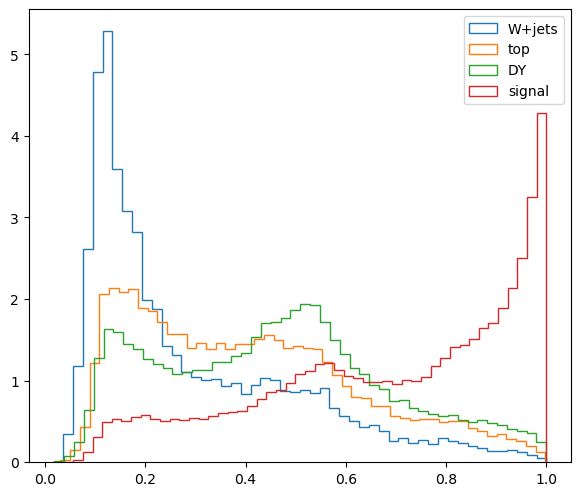

In [12]:
wjets = bkg[bkg.sample_name == "Wjets"]
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], weights=wjets.weight*wjets.XSWeight,   bins=50,density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"], bins=50,density=True, label="top", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"], bins=50,density=True, label="DY", histtype="step")
#plt.hist(bkg["y"], bins=50,density=True, label="Tot. bkg", histtype="step")
plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.hist(results[y_test==0], bins=50,density=True, label="false", histtype="step")
#plt.hist(results[y_test==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

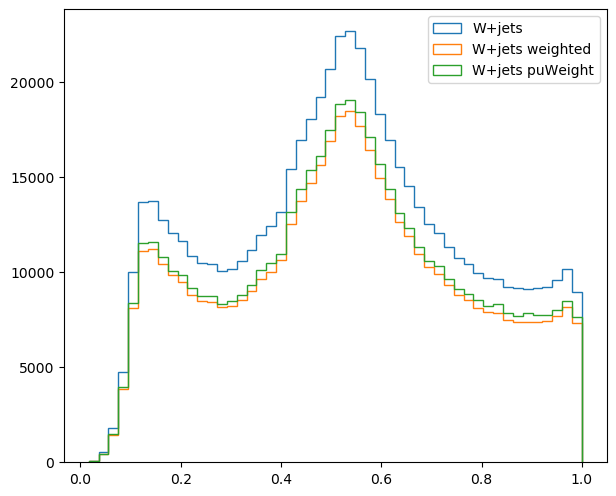

In [13]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
wjet = bkg[bkg["sample_name"] == "Wjets"]
plt.hist(wjet["y"], bins=50, label="W+jets", histtype="step")
plt.hist(wjet["y"], weights=wjet["weight"], bins=50, label="W+jets weighted", histtype="step")
plt.hist(wjet["y"], weights=wjet["weight"]*wjet["puWeight"],bins=50, label="W+jets puWeight", histtype="step" )
#plt.yscale("log")
plt.legend()

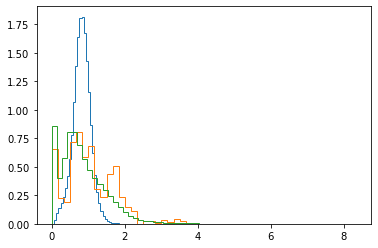

In [14]:
plt.hist(wjet["weight"],bins=50, histtype="step", density=True)
_ = plt.hist(wjet["puWeight"], bins=50, histtype="step", density=True)
_ = plt.hist(wjet["puWeight"]*wjet["weight"], bins=50, histtype="step", density=True)

(array([9.24088190e-01, 2.28410305e-01, 0.00000000e+00, 6.30907235e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.79544926e-01,
        1.42726853e+00, 1.83637340e-01, 6.94770683e-01, 1.05363326e+00,
        3.52729147e-01, 1.33545062e+00, 1.19067832e+00, 7.55231286e-01,
        2.88635514e-01, 6.01134595e-01, 3.53638243e+00, 2.49158358e+00,
        4.21362397e+00, 2.97910674e+00, 6.62657141e+00, 6.83634352e+00,
        1.56203103e+01, 1.84997183e+01, 2.58015150e+01, 2.56374090e+01,
        9.20929109e+00, 4.05589716e+00, 1.64022245e+00, 7.52725058e-01,
        2.57730770e-01, 1.14545118e-01, 2.32044772e-01, 1.77272206e-02,
        7.99997646e-02, 0.00000000e+00, 2.11366505e-02, 0.00000000e+00,
        0.00000000e+00, 4.99998529e-02]),
 array([0.73777175, 0.74499094, 0.7522101 , 0.7594293 , 0.7666485 ,
        0.7738676 , 0.7810

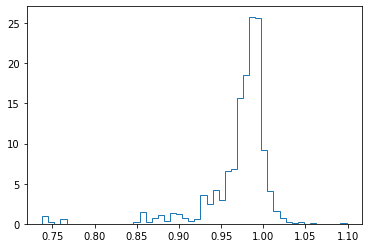

In [16]:
plt.hist(wjet["LepWPWeight"], bins=50, density=True, histtype="step")

In [37]:
with open(f"{samples_dir}/{cut}/models/scaler.txt") as ifile:
    l = ifile.readlines()

In [43]:
a = "726.096(-0.571372) | 86.4375(-0.818756) | 64.75(-0.473159) | 1.9646(0.451289) | 2.56299(0.315718) | 1(1.20761) | 3(0.804023) | 4.52759(0.674675) | 2.43555(0.361432) | 184.695(9.64094) | 88.875(-0.131151) | 67.5(1.46933) | 1.04932(0.113146) | 2.23047(1.68678) | 0(-1.70437) | 2(-1.52953) | 61.0129(-0.447528) | 1.82422(0.967764) | 13(0.860881) | 105.174(-0.0402902) | 0(-4.56839) | 2(0.0202117) | 1(-0.142992) | -0.165678(-0.453072) | -0.336829(-0.702233) | 0.143448(-0.864211) | 0.136691(-0.702083) | 0.915667(0.920596) | 142.273(0.269505) | 121.448(0.756477) | 113.44(-0.413992) | 350.633(-0.305096) | 2.29926(-0.0783974) | 0.0626485(0.466448) | 1.58968(1.80226) | -1.08778(-1.17716) |"

In [50]:
import re

reg = r"[(](?P<n>-*\d*[.]*\d*)[)]"

inp = np.array(re.findall(reg, a), dtype=float)

In [51]:
inp

array([-0.571372 , -0.818756 , -0.473159 ,  0.451289 ,  0.315718 ,
        1.20761  ,  0.804023 ,  0.674675 ,  0.361432 ,  9.64094  ,
       -0.131151 ,  1.46933  ,  0.113146 ,  1.68678  , -1.70437  ,
       -1.52953  , -0.447528 ,  0.967764 ,  0.860881 , -0.0402902,
       -4.56839  ,  0.0202117, -0.142992 , -0.453072 , -0.702233 ,
       -0.864211 , -0.702083 ,  0.920596 ,  0.269505 ,  0.756477 ,
       -0.413992 , -0.305096 , -0.0783974,  0.466448 ,  1.80226  ,
       -1.17716  ])

In [54]:
model.predict(np.array([inp]))

array([[0.30142498]], dtype=float32)

In [41]:
scaler.scale_

array([8.46335884e+02, 2.76579411e+02, 1.77297654e+02, 9.51182519e-01,
       1.08739981e+00, 6.06909430e-01, 1.18741468e+00, 1.24078604e+00,
       8.48701409e-01, 1.03096831e+01, 7.68666235e+01, 1.56707771e+01,
       7.23819485e-01, 7.29768253e-01, 1.14918494e+00, 1.10385602e+00,
       1.00734865e+02, 6.81742232e-01, 9.88884058e-01, 1.14621331e+02,
       1.11905280e+00, 1.58129582e+00, 1.19399079e+00, 3.64925957e-01,
       4.79570127e-01, 2.44018592e-01, 2.17509746e-01, 2.61633219e-01,
       1.03852266e+02, 5.71982227e+01, 1.73849812e+02, 2.42977310e+02,
       8.05476762e+00, 5.45340548e-02, 3.32291938e-01, 1.00158982e+00])